In [1]:
import processing
import ds
import ml
import model_saving
import TS

/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


In [2]:
filename = '/home/octo/Dropbox'+ '/SPY21Dec.csv'

In [3]:
data=processing.get_csv_pd(filename)
data=processing.BA(data)
data=processing.preprocessing(data)
data_km=ml.kalman_ma(data)
data['km']=data_km

In [4]:
import numpy as np
data['diff']=np.where(np.logical_and(data.Open>data.km,data.spread>0),data.vwap-data.km,np.where(np.logical_and(data.Open<data.km,data.spread<0),data.vwap-data.km,0))

#### ARIMA to predict data.CKM

In [5]:
data_arima=np.log(data.Close).diff().diff(12)

In [6]:
data_arima.tail()

2017-12-22 08:43:41.354203   0.00000
2017-12-22 08:43:43.959309   0.00000
2017-12-22 08:43:46.158100   0.00000
2017-12-22 08:43:48.568004   0.00000
2017-12-22 08:43:51.341810   0.00000
Name: Close, dtype: float32

### Using Fraction of data

In [7]:
data_arima=data_arima[5000:22000]

In [8]:
data_arima.head(2)

2017-12-21 20:18:33.057262    0.00000
2017-12-21 20:18:33.525860   -0.00002
Name: Close, dtype: float32

In [9]:
data_arima.tail(2)

2017-12-22 00:26:48.501306   0.00000
2017-12-22 00:26:49.972900   0.00000
Name: Close, dtype: float32

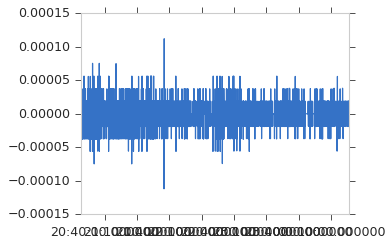

In [10]:
import numpy as np
X = data_arima.astype('float32')
#ts_log = np.log(X)
import matplotlib.pyplot as plt
plt.plot(X)
plt.show()

In [11]:
%matplotlib inline
import os.path
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import statsmodels.api as sm
import statsmodels.tsa.api as smt

from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
plt.style.use('ggplot')

In [12]:
predict_time = 5

In [13]:
split = len(data_arima) - predict_time
train_data, prediction_data = data_arima[0:split],data_arima[split:]
train_data.tail(5)

2017-12-22 00:26:36.701837   0.00000
2017-12-22 00:26:38.200312   0.00000
2017-12-22 00:26:39.823648   0.00000
2017-12-22 00:26:41.421149   0.00000
2017-12-22 00:26:42.700271   0.00000
Name: Close, dtype: float32

In [14]:
prediction_data

2017-12-22 00:26:43.994664   0.00000
2017-12-22 00:26:45.269204   0.00002
2017-12-22 00:26:46.876756   0.00000
2017-12-22 00:26:48.501306   0.00000
2017-12-22 00:26:49.972900   0.00000
Name: Close, dtype: float32

### Stationarity
Stationarity is defined using very strict criterion. However, for practical purposes we can assume the series to be stationary if it has constant statistical properties over time, ie. the following:

constant mean
constant variance
an autocovariance that does not depend on time.

In [15]:
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
import pandas as pd 

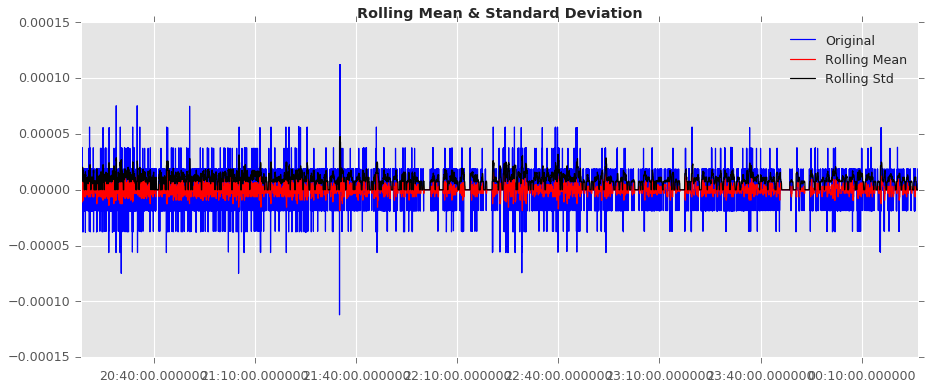

Results of Dickey-Fuller Test:
Test Statistic                  -29.75870
p-value                           0.00000
#Lags Used                       43.00000
Number of Observations Used   16956.00000
Critical Value (1%)              -3.43074
Critical Value (5%)              -2.86171
Critical Value (10%)             -2.56686
dtype: float64


In [16]:
rcParams['figure.figsize'] = 15, 6
TS.test_stationarity(data_arima)
plt.show()

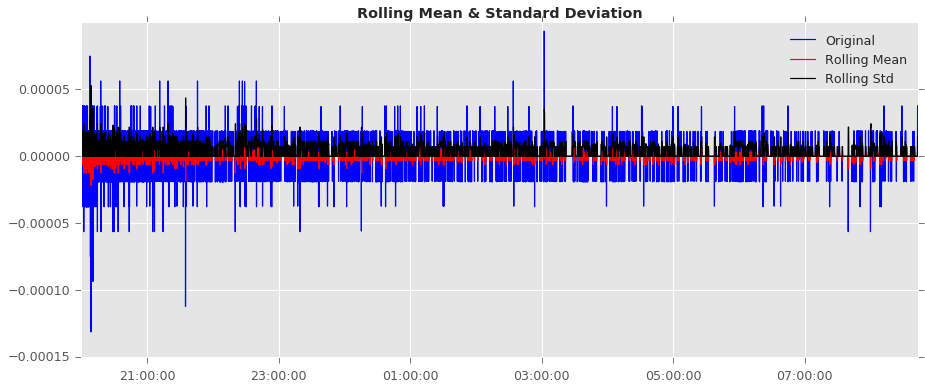

Results of Dickey-Fuller Test:
Test Statistic                  -36.41231
p-value                           0.00000
#Lags Used                       27.00000
Number of Observations Used   37170.00000
Critical Value (1%)              -3.43053
Critical Value (5%)              -2.86162
Critical Value (10%)             -2.56681
dtype: float64


In [19]:
rcParams['figure.figsize'] = 15, 6
TS.test_stationarity(np.log(data.Close).diff().dropna())
plt.show()

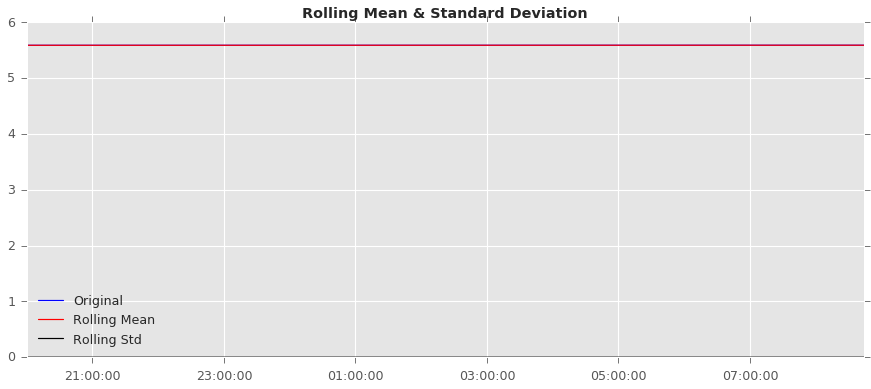

Results of Dickey-Fuller Test:
Test Statistic                   -1.01280
p-value                           0.74857
#Lags Used                       28.00000
Number of Observations Used   37170.00000
Critical Value (1%)              -3.43053
Critical Value (5%)              -2.86162
Critical Value (10%)             -2.56681
dtype: float64


In [20]:
rcParams['figure.figsize'] = 15, 6
TS.test_stationarity(np.log(data.Close))
plt.show()

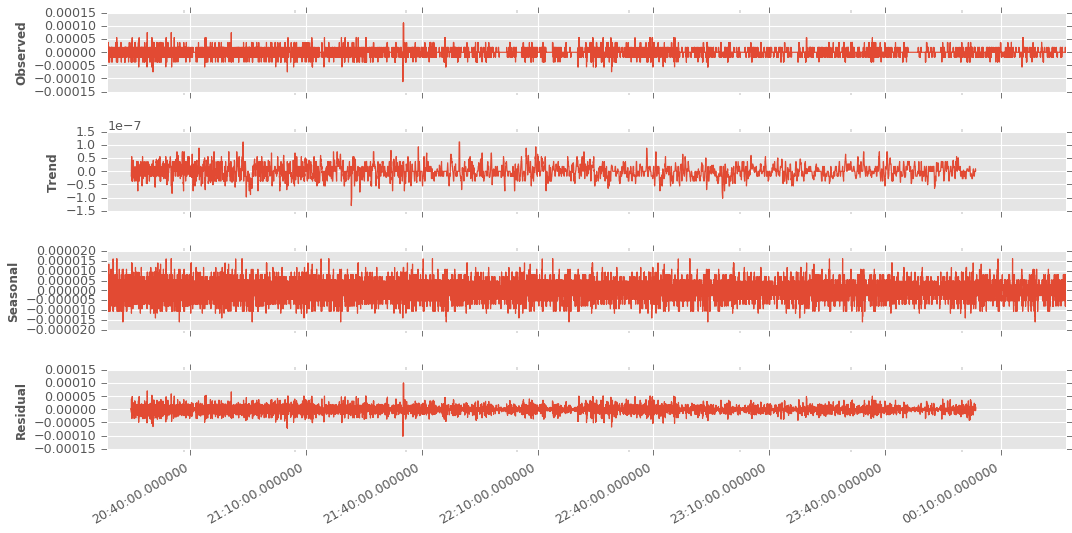

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data_arima, freq=2000)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)
plt.show()

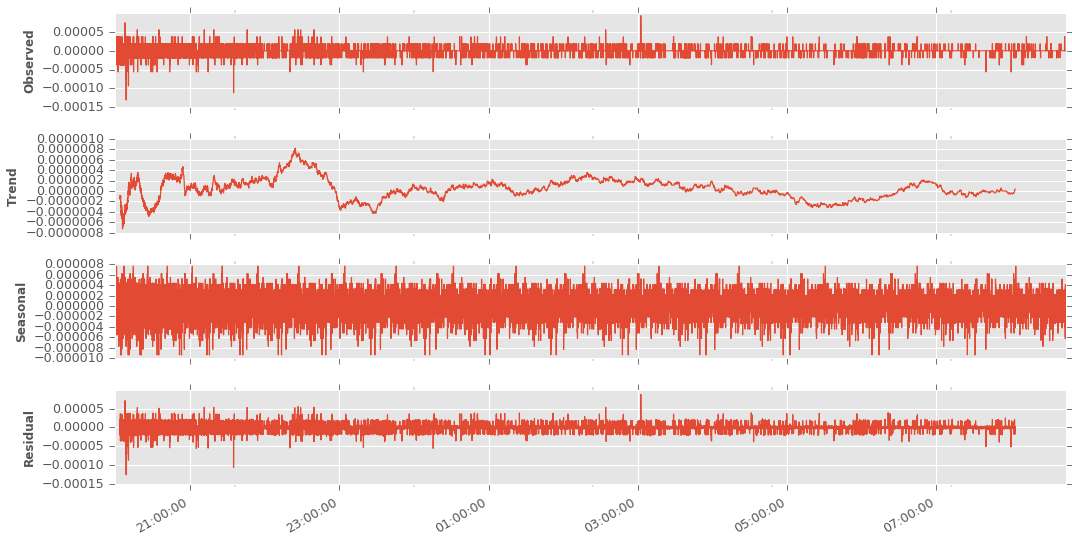

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(np.log(data.Close).diff().dropna(), freq=2000)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)
plt.show()

In [24]:
train_data.shape[0]

16995

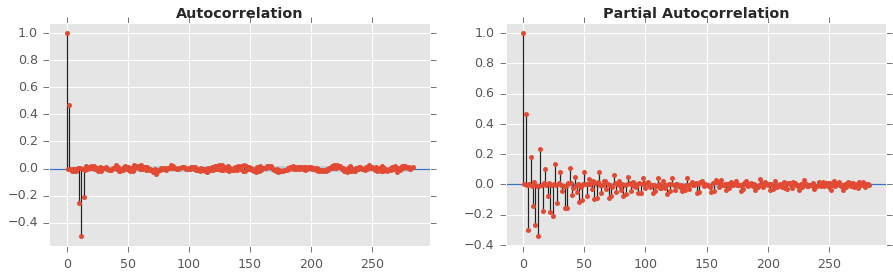

In [25]:
# rendering such a large time series is compute intensive so I'm breaking it up
didive_large_series_by = 60
fig, axes = plt.subplots(1, 2, figsize=(15,4))
fig = plot_acf(train_data,
               lags = abs(train_data.shape[0]/didive_large_series_by),
               ax=axes[0])
fig = plot_pacf(train_data,
                lags = abs(train_data.shape[0]/didive_large_series_by),
                ax=axes[1])

The autocorrelation plot indicates that the time series are not stationary because the values are not reduced at a significant pace. The partial autocorrelation graph above indicates that the value on lag 6 is the only one which is significantly different from 0, so a model AR(6) should be enough.

These are the manual steps that can be followed in order to check a signal for stationarity and transform it to be usable for the ARMA models. Since this process is quite manual and there needs to be way to let the program decide whether a time series is stationary or not

### Ad-fuller test

In [26]:
from collections import namedtuple

ADF = namedtuple('ADF', 'adf pvalue usedlag nobs critical icbest')
stationarity_results = ADF(*smt.adfuller(train_data))._asdict()
significance_level = 0.01

if (stationarity_results['pvalue'] > significance_level):
    message = 'For p-value={:0.4f}, the time series are probably non-stationary'
    print(message.format(stationarity_results['pvalue']))
else:
    message = 'For p-value={:0.4f}, the time series are probably stationary'
    print(message.format(stationarity_results['pvalue']))

print(stationarity_results['critical'])

For p-value=0.0000, the time series are probably stationary
{'1%': -3.4307358350859833, '5%': -2.8617105238580689, '10%': -2.5668607654836255}


In [27]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults

In [28]:
from pandas import Series
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
#from statsmodels.graphics.tsaplots import plot_pacf
#from matplotlib import pyplot as plt
import pandas
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import numpy as np
import math
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.arima_model import ARIMA

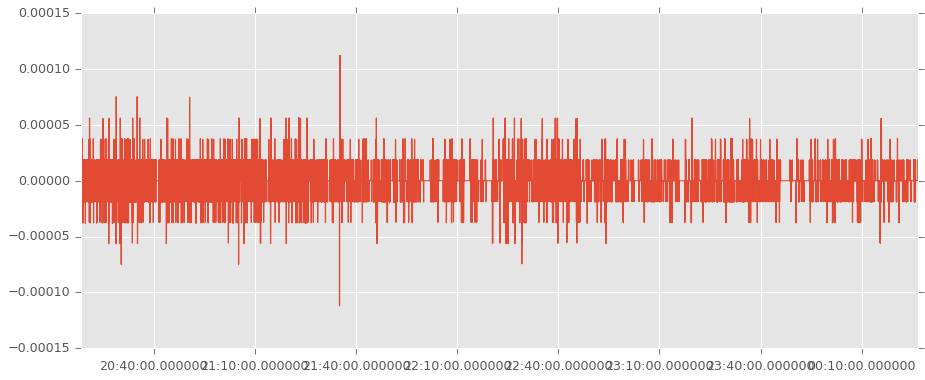

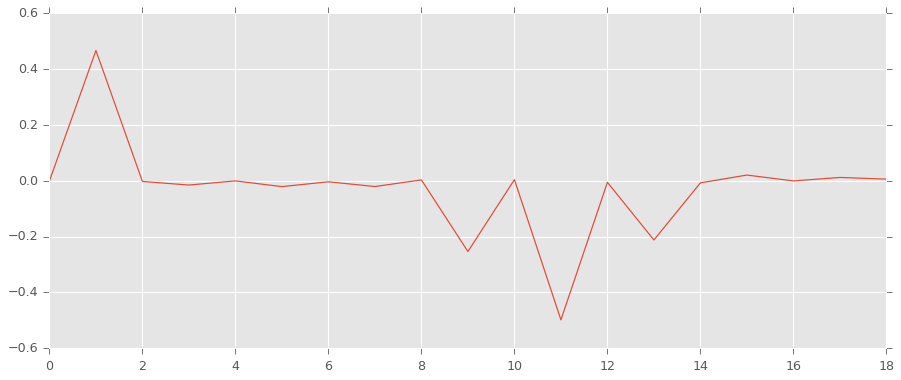

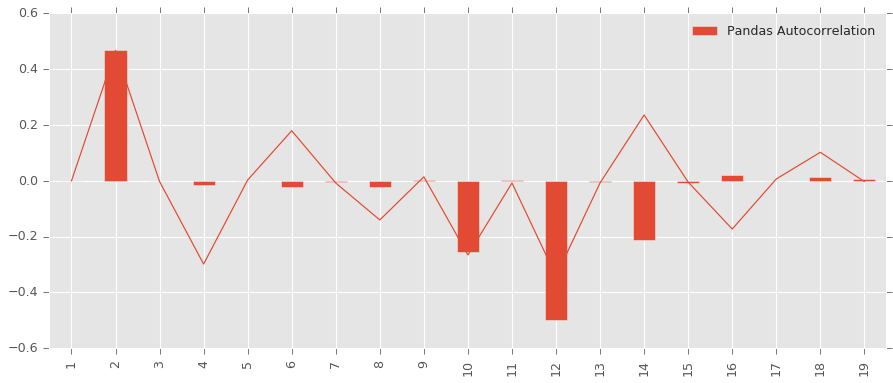

(-55.582175664757628,
 0.0,
 1,
 16998,
 {'1%': -3.4307347680787657,
  '10%': -2.5668605144872769,
  '5%': -2.8617100523136081},
 -342730.39874645881)

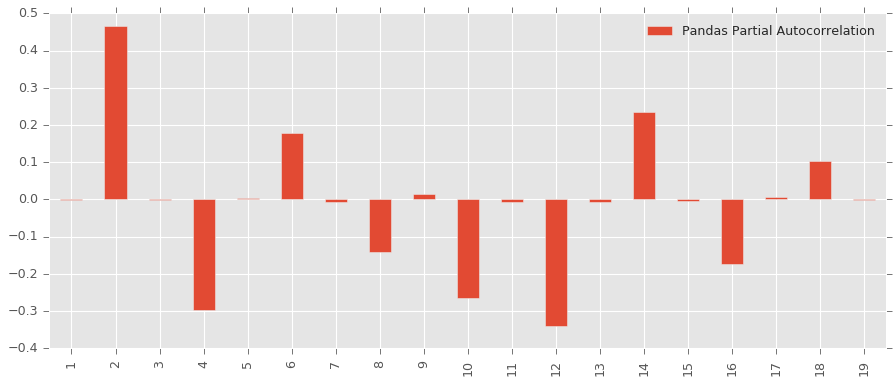

In [29]:
ret=data_arima
#ret=X
plt.plot(ret)
plt.show()
acf_1 =  acf(ret)[1:20]
plt.plot(acf_1)
plt.show()
test_df = pandas.DataFrame([acf_1]).T
test_df.columns = ['Pandas Autocorrelation']
test_df.index += 1
test_df.plot(kind='bar')
pacf_1 =  pacf(ret)[1:20]
plt.plot(pacf_1)
plt.show()
test_df = pandas.DataFrame([pacf_1]).T
test_df.columns = ['Pandas Partial Autocorrelation']
test_df.index += 1
test_df.plot(kind='bar')
result = ts.adfuller(ret, 1)
result

#### so, p=6, q=2,d=0

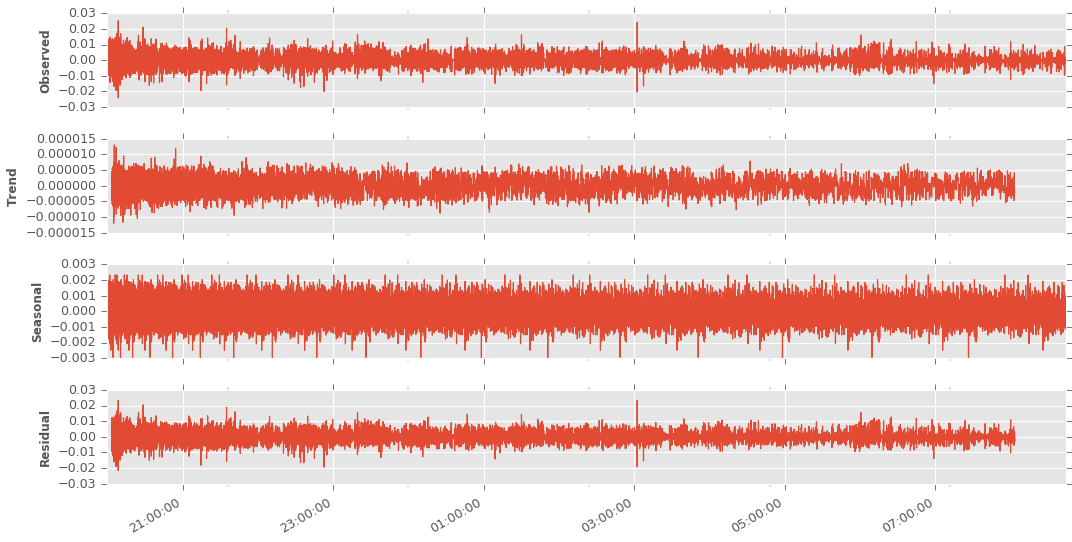

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose
y=data.spread.diff()
decomposition = seasonal_decompose(y.dropna(), freq=2000)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)
plt.show()

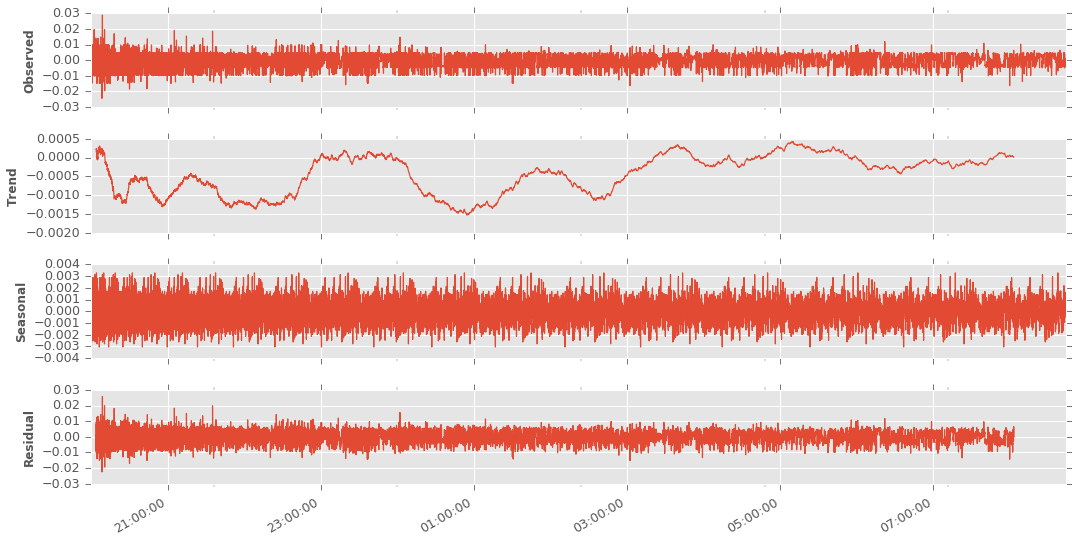

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data.spread, freq=2000)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)
plt.show()

In [39]:
order = (4,0,3) # if the series are stationary, there is no need for an integrated order
mod = ARIMA(data_arima, order = order, freq = 'D')

results = mod.fit()
print(results.summary())
print('DW test is {}'.format(sm.stats.durbin_watson(results.resid.values)))

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                17000
Model:                     ARMA(4, 3)   Log Likelihood              172332.634
Method:                       css-mle   S.D. of innovations              0.000
Date:                Tue, 06 Feb 2018   AIC                        -344647.267
Time:                        19:15:38   BIC                        -344577.598
Sample:                    12-21-2017   HQIC                       -344624.293
                         - 12-22-2017                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.597e-09   1.18e-07     -0.014      0.989   -2.33e-07     2.3e-07
ar.L1.Close     0.0068      0.101      0.068      0.946      -0.192       0.206
ar.L2.Close     0.4884      0.024     19.973    

In [40]:
prediction_data.index[0]

Timestamp('2017-12-22 00:26:43.994664')

In [41]:
prediction_data.index[-1]

Timestamp('2017-12-22 00:26:49.972900')

In [45]:
prediction_data[-1]

0.0

In [42]:
prediction_data

2017-12-22 00:26:43.994664   0.00000
2017-12-22 00:26:45.269204   0.00002
2017-12-22 00:26:46.876756   0.00000
2017-12-22 00:26:48.501306   0.00000
2017-12-22 00:26:49.972900   0.00000
Name: Close, dtype: float32

In [55]:
prediction = mod.predict('2017-12-22 00:26:43.994664','2017-12-22 00:26:49.972900')
#prediction.tail(predict_days)

ValueError: could not broadcast input array from shape (0,1) into shape (3,1)

ValueError: Wrong number of items passed 5, placement implies 1

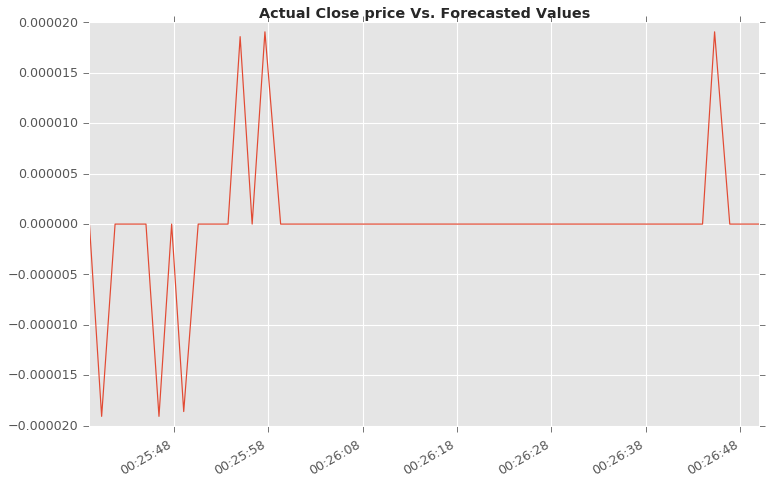

In [53]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.title("Actual Close price Vs. Forecasted Values")
ax = data_arima.ix[len(data_arima)-predict_time*10:].plot(ax=ax)
fig = results.plot_predict(prediction_data.index[0],
                           prediction_data.index[-1],
                           dynamic=True,
                           ax=ax,
                           plot_insample=False)
legend = ax.legend(loc='upper left')